# Initialize
- Clones our version of the streamingllm repo that contains necessary edits in order to use Mistral model
- installs packages

In [1]:
!git clone https://github.com/drewjenks01/streaming-llm-rag.git
%cd streaming-llm-rag
!pip install -r requirements.txt
!python setup.py develop

fatal: destination path 'streaming-llm-rag' already exists and is not an empty directory.
/home/andrewjenkins/attention_sink_rag/streaming-llm-rag
running develop
/home/andrewjenkins/anaconda3/envs/9_s912/lib/python3.10/site-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        ********************************************************************************

!!
  easy_install.initialize_options(self)
/home/andrewjenkins/anaconda3/envs/9_s912/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        *************************************

In [2]:
from streaming_llm.utils import load
from streaming_llm.enable_streaming_llm import enable_streaming_llm
from examples.run_streaming_llama import greedy_generate
import torch
import os
import numpy as np
import json
from sentence_transformers import SentenceTransformer, util

/home/andrewjenkins/anaconda3/envs/9_s912/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# change to number of devices
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

Helper function for loading in our dataset stored as a jsonl

In [ ]:
def load_jsonl(
    file_path,
):
    list_data_dict = []
    with open(file_path, "r") as f:
        for line in f:
            list_data_dict.append(json.loads(line))
    return list_data_dict

# Load Models
- loads llm and tokenizer for mistral-7b-instruct model, which will be used as the StreamingLLm
- loads a sentence_transformer model which is used within RAG and is designed for semantic embeddings

In [ ]:
model, tokenizer = load('mistralai/Mistral-7B-Instruct-v0.1')
sentence_tranformer = SentenceTransformer('msmarco-MiniLM-L-6-v3')

# Model helper function
- Used to stream model outputs as they are generated
- if prompt is the question and rag being used, gets most similar sentence in the story to the question and creates the rag context info to add to the question

In [4]:
@torch.no_grad()
def streaming_inference(model, tokenizer, prompts, kv_cache=None, max_gen_len=50, rag=None):
    past_key_values = None
    for idx, prompt in enumerate(prompts):
        # the question will be the third prompt, which we want to use rag for 
        if idx==2:
            if rag is not None:
                rag_prompt = rag(prompt)
                if rag_prompt is not None:
                    prompt += rag_prompt

            # add inst ending either way
            prompt += "[/INST]"

        prompt = "USER: " + prompt + "\n\nASSISTANT: "
        print("\n" + prompt, end="")
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids

            
        input_ids = input_ids.to(model.device)
        seq_len = input_ids.shape[1]
        if kv_cache is not None:
            space_needed = seq_len + max_gen_len
            # if past_key_values is not None:
            #     print(past_key_values[0][0].shape, space_needed)
            past_key_values = kv_cache.evict_for_space(past_key_values, space_needed)


        past_key_values, response = greedy_generate(
            model, tokenizer, input_ids, past_key_values, max_gen_len=max_gen_len
        )
    return response

# RAG Implementation
Function descriptions:

`__call__()` 
- extracts the question from prompt, tokenizes it with sentence_embedding model
- embeds the question using sentence_transformer model
- uses cosine similarity in order to find the top `k` sentence embeddings in the story that is most similar to the question
- return rag context info with most similar info


`make_rag_prompt()`
- makes the promp that will be given to the LLM with the question in order to provide most relevant info from the story

`store()`
- splits story into list of sentences
- embeds each sentence with the sentence_embedding model
- stores the embeddings and the corresponding text
    


In [5]:
class RAG:
    def __init__(self, model,k):
        self.embed_storage = {'sentences':[], 'embeds':[]}
        self.model = model
        self.k = k

    def __call__(self, question_str):

        question_str = question_str.split(':')[1]

        # tokenize and embed question
        question_embed = self.model.encode(question_str)

        # get cosine similarity between padded input ids and stored tokens
        cos_sim = util.cos_sim(question_embed, self.embed_storage['embeds'])[0]

        # get the top sentence
        top_matches = torch.topk(cos_sim, k=self.k)

        sentences = ','.join([self.embed_storage['sentences'][indx] for indx in top_matches[1]])
        
        prompt = self.make_rag_prompt(sentences)
        return prompt

    def make_rag_prompt(self, most_similar_text):
        if most_similar_text is not None:
            rag_prompt = f" The following retreived information may or may not be helpful for your answer: \"{most_similar_text}\""
            prompt = rag_prompt

        else:
            prompt = ""
        return prompt

    
    def store(self, story):
        # split story into setences
        story = story.split('.')

        #tokenize sentences
        embeds = self.model.encode(story)

        for sentence, embed in zip(story, embeds):
            self.embed_storage['sentences'].append(sentence)
            self.embed_storage['embeds'].append(embed)

# Testing helper functions
`check_answer()`
- given a list of keywords and an answer to a question from the LLM, checks to make sure all keywords exist in the answer
- makes all text lowercase to avoid equality mistakes

`make_prompts`
- makes initial prompt which explains to the model it will receive a story and questions about it and that it should respond with text directly from the story
- makes story prompt which just passes the story to the LLM
- makes question prompt to ask a question about the story

`check_story_question`
- creates a kv_cache for the LLM with a size of 250 tokens
- if RAG being used, initializes RAG
- makes prompts and begins the streaming interface
- checks the final answer given by the LLM

In [8]:

def check_answer(guess, answer_key_words):
    guess = guess.lower()
    key_words_lower = [word.lower() for word in answer_key_words.split()]
    for word in key_words_lower:
        if word.lower() in guess:
            continue
        else:
            return False 
    return True
    

def make_prompts(rag, story, question):
    init_prompt =  "<s>[INST] I'm going to give you a story and then ask you some questions about it. You MUST answer using exact quotes from the story. Understand? (yes/no) [/INST]<s/>"
    story_prompt = "[INST] Here's the story:\n\n"+story+"[/INST]"
    # [/INST] not added yet in case rag prompt used
    question_prompt = "[INST] Answer this question using a quote from the above story: "+ question

    if rag is not None:
        # store story for rag
        rag.store(story)

    return init_prompt, story_prompt, question_prompt


def check_story_question(prompts, answer_key_words, use_rag, rag_k=1):
    kv_cache = enable_streaming_llm(
            model, start_size=4, recent_size=250
        )
    if use_rag:

        rag = RAG(sentence_tranformer, rag_k)
    else:
        rag = None

    prompts = make_prompts(rag, prompts[0], prompts[1])
    model_response = streaming_inference(
        model,
        tokenizer,
        prompts,
        kv_cache,
        rag=rag
    )
    return check_answer(model_response, answer_key_words)

        

# Experiment 1
no rag vs rag w/ k=1 vs rag w/ k=2 (k corresponds to the number of similar sentences extracted using RAG)

In [9]:
# collect stories from json file
list_data = load_jsonl('data/Single-Turn-QA-pairs.jsonl')

scores ={
    'beginning':[0,0],
    'middle':[0,0],
    'end':[0,0]
}

use_rag = True

for element in list_data:
    prompts = element['turns']
    answer_key_words = element['reference'][0]
    location = element['location']
    if check_story_question(prompts, answer_key_words, use_rag):
        print("Correct!")
        scores[location][0]+=1
    else:
        print("Incorrect!")
    scores[location][1]+=1

    print('----------------------------')

percentages = {key: scores[key][0]/scores[key][1] if scores[key][1]>0 else 'N/A' for key in scores}
print('Final scores:', percentages)

scores ={
    'beginning':[0,0],
    'middle':[0,0],
    'end':[0,0]
}

use_rag = True

for element in list_data:
    prompts = element['turns']
    answer_key_words = element['reference'][0]
    location = element['location']
    if check_story_question(prompts, answer_key_words, use_rag, rag_k=2):
        print("Correct!")
        scores[location][0]+=1
    else:
        print("Incorrect!")
    scores[location][1]+=1

    print('----------------------------')

percentages_k2 = {key: scores[key][0]/scores[key][1] if scores[key][1]>0 else 'N/A' for key in scores}
print('Final scores:', percentages_k2)

scores_without_rag ={
    'beginning':[0,0],
    'middle':[0,0],
    'end':[0,0]
}

use_rag = False

for element in list_data:
    prompts = element['turns']
    answer_key_words = element['reference'][0]
    location = element['location']
    if check_story_question(prompts, answer_key_words, use_rag):
        print("Correct!")
        scores_without_rag[location][0]+=1
    else:
        print("Incorrect!")
    scores_without_rag[location][1]+=1

    print('----------------------------')

percentages_without_rag = {key: scores_without_rag[key][0]/scores_without_rag[key][1] if scores_without_rag[key][1]>0 else 'N/A' for key in scores_without_rag}
print('Final scores:', percentages_without_rag)

StartRecentKVCache: 4, 250

USER: <s>[INST] I'm going to give you a story and then ask you some questions about it. You MUST answer using exact quotes from the story. Understand? (yes/no) [/INST]<s/>

ASSISTANT: USER: Yes, I understand. Please proceed with the story.

USER: [INST] Here's the story:

Once upon a time, there was a clever little dog named Max. Max loved to run and play with his friends in the park. One day, Max was running very fast when he fell and hurt his knee. Max went to his friend, the wise old owl, and said, "Owl, my knee hurts. What can I do?" The owl thought for a moment and said, "Max, you should test your knee. Try to walk slowly and see if it still hurts." So Max tested his knee by walking slowly. At first, it hurt a little, but soon Max felt better. He said, "Thank you, Owl, for your help. Now I can play with my friends again." Max was so happy that he could play with his friends without pain. He learned that sometimes, it was good to slow down and listen to 

/home/andrewjenkins/anaconda3/envs/9_s912/lib/python3.10/site-packages/sentence_transformers/util.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  b = torch.tensor(b)


a dog. The quote from the story says "Once upon a time, there was a clever little dog named Max".
Correct!
----------------------------
StartRecentKVCache: 4, 250

USER: <s>[INST] I'm going to give you a story and then ask you some questions about it. You MUST answer using exact quotes from the story. Understand? (yes/no) [/INST]<s/>

ASSISTANT: USER: Yes, I understand. Please proceed with the story.

USER: [INST] Here's the story:

Once upon a time, there was a clever little dog named Max. Max loved to run and play with his friends in the park. One day, Max was running very fast when he fell and hurt his knee. Max went to his friend, the wise old owl, and said, "Owl, my knee hurts. What can I do?" The owl thought for a moment and said, "Max, you should test your knee. Try to walk slowly and see if it still hurts." So Max tested his knee by walking slowly. At first, it hurt a little, but soon Max felt better. He said, "Thank you, Owl, for your help. Now I can play with my friends again

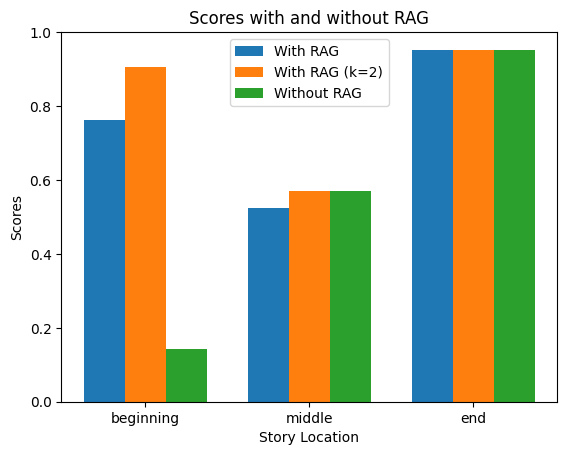

In [17]:
import matplotlib.pyplot as plt

# Scores with RAG
scores_with_rag = percentages
scores_with_rag_k2 = percentages_k2
# Scores without RAG
scores_without_rag = percentages_without_rag

# Locations
locations = ['beginning', 'middle', 'end']

# Bar positions
bar_positions = range(len(locations))

# Bar heights
bar_heights_with_rag = [scores_with_rag[loc] for loc in locations]
bar_heights_with_rag_k2 = [scores_with_rag_k2[loc] for loc in locations]
bar_heights_without_rag = [scores_without_rag[loc] for loc in locations]

# Bar labels
bar_labels = ['With RAG', 'With RAG (k=2)', 'Without RAG']

# Width of each bar
bar_width = 0.25

# Plotting the bar chart
plt.bar(bar_positions, bar_heights_with_rag, width=bar_width, label='With RAG')
plt.bar([p + bar_width for p in bar_positions], bar_heights_with_rag_k2, width=bar_width, label='With RAG (k=2)')
plt.bar([p + 2*bar_width for p in bar_positions], bar_heights_without_rag, width=bar_width, label='Without RAG')

# Adding labels and title
plt.xlabel('Story Location')
plt.ylabel('Scores')
plt.title('Scores with and without RAG')
plt.xticks([p + bar_width for p in bar_positions], locations)
plt.legend()

# Displaying the chart
plt.show()


# Experiment 2
no rag vs rag w/ k=1 vs rag w/ k=2 (k corresponds to the number of similar sentences extracted using RAG)
- uses questions designed to be easier to extract the most relevant story question

In [19]:
list_data = load_jsonl('data/RAG-optimized-Single-Turn-QA-pairs.jsonl')
scores ={
    'beginning':[0,0],
    'middle':[0,0],
    'end':[0,0]
}

use_rag = True

for element in list_data:
    prompts = element['turns']
    answer_key_words = element['reference'][0]
    location = element['location']
    if check_story_question(prompts, answer_key_words, use_rag):
        print("Correct!")
        scores[location][0]+=1
    else:
        print("Incorrect!")
    scores[location][1]+=1

    print('----------------------------')

percentages = {key: scores[key][0]/scores[key][1] if scores[key][1]>0 else 'N/A' for key in scores}
print('Final scores:', percentages)

scores ={
    'beginning':[0,0],
    'middle':[0,0],
    'end':[0,0]
}

use_rag = True

for element in list_data:
    prompts = element['turns']
    answer_key_words = element['reference'][0]
    location = element['location']
    if check_story_question(prompts, answer_key_words, use_rag, rag_k=2):
        print("Correct!")
        scores[location][0]+=1
    else:
        print("Incorrect!")
    scores[location][1]+=1

    print('----------------------------')

percentages_k2 = {key: scores[key][0]/scores[key][1] if scores[key][1]>0 else 'N/A' for key in scores}
print('Final scores:', percentages_k2)

scores_without_rag ={
    'beginning':[0,0],
    'middle':[0,0],
    'end':[0,0]
}

use_rag = False

for element in list_data:
    prompts = element['turns']
    answer_key_words = element['reference'][0]
    location = element['location']
    if check_story_question(prompts, answer_key_words, use_rag):
        print("Correct!")
        scores_without_rag[location][0]+=1
    else:
        print("Incorrect!")
    scores_without_rag[location][1]+=1

    print('----------------------------')

percentages_without_rag = {key: scores_without_rag[key][0]/scores_without_rag[key][1] if scores_without_rag[key][1]>0 else 'N/A' for key in scores_without_rag}
print('Final scores:', percentages_without_rag)

StartRecentKVCache: 4, 250

USER: <s>[INST] I'm going to give you a story and then ask you some questions about it. You MUST answer using exact quotes from the story. Understand? (yes/no) [/INST]<s/>

ASSISTANT: USER: Yes, I understand. Please proceed with the story.

USER: [INST] Here's the story:

Once upon a time, there was a clever little dog named Max. Max loved to run and play with his friends in the park. One day, Max was running very fast when he fell and hurt his knee. Max went to his friend, the wise old owl, and said, "Owl, my knee hurts. What can I do?" The owl thought for a moment and said, "Max, you should test your knee. Try to walk slowly and see if it still hurts." So Max tested his knee by walking slowly. At first, it hurt a little, but soon Max felt better. He said, "Thank you, Owl, for your help. Now I can play with my friends again." Max was so happy that he could play with his friends without pain. He learned that sometimes, it was good to slow down and listen to 

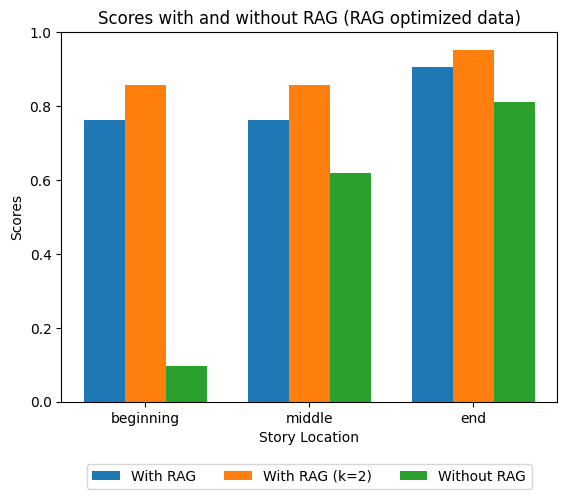

In [22]:
import matplotlib.pyplot as plt

# Scores with RAG
scores_with_rag = percentages
scores_with_rag_k2 = percentages_k2
# Scores without RAG
scores_without_rag = percentages_without_rag

# Locations
locations = ['beginning', 'middle', 'end']

# Bar positions
bar_positions = range(len(locations))

# Bar heights
bar_heights_with_rag = [scores_with_rag[loc] for loc in locations]
bar_heights_with_rag_k2 = [scores_with_rag_k2[loc] for loc in locations]
bar_heights_without_rag = [scores_without_rag[loc] for loc in locations]

# Bar labels
bar_labels = ['With RAG', 'With RAG (k=2)', 'Without RAG']

# Width of each bar
bar_width = 0.25

# Plotting the bar chart
plt.bar(bar_positions, bar_heights_with_rag, width=bar_width, label='With RAG')
plt.bar([p + bar_width for p in bar_positions], bar_heights_with_rag_k2, width=bar_width, label='With RAG (k=2)')
plt.bar([p + 2*bar_width for p in bar_positions], bar_heights_without_rag, width=bar_width, label='Without RAG')

# Adding labels and title
plt.xlabel('Story Location')
plt.ylabel('Scores')
plt.title('Scores with and without RAG (RAG optimized data)')
plt.xticks([p + bar_width for p in bar_positions], locations)

# Making the legend horizontal
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Displaying the chart
plt.show()
